In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
plt.rc('font', size=16)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### FashionMNIST dataset

In [2]:
fmnist_train = datasets.FashionMNIST(
    root="../../../data", train=True, transform=transforms.ToTensor(), download=True)
fmnist_test = datasets.FashionMNIST(
    root="../../../data", train=False, transform=transforms.ToTensor(), download=True)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
batch_size = 128

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=True)

#### Loss Function

In [4]:
criterion = nn.CrossEntropyLoss()

## LeNet

- See [§6.6](./6.4-6.6%20CNN_2.ipynb) for details of LeNet.

In [5]:
net0 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), 
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

net0.to(device)

# count total network parameters
print('Total network parameters :', sum(param.numel() for param in net0.parameters() if param.requires_grad))

Total network parameters : 61706


## LeNet with BatchNorm

In [6]:
netB = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

netB.to(device)

# count total network parameters
print('Total network parameters :', sum(param.numel() for param in netB.parameters() if param.requires_grad))

Total network parameters : 62158


### The number of trainable parameters for LeNet with BatchNorm. 

- Compared with the original LeNet. There are an extra 62158-61706 = 452 trainable parameters for LeNet with BatchNorm.
    - 226 parameters for the rescale parameters ${\mathbf \gamma}$. (226 = 6+16+120+84)
    - 226 parameters for the shift parameters ${\mathbf \beta}$.

#### Optimizer

In [7]:
learning_rate = 0.5

optimizer0 = torch.optim.SGD(net0.parameters(), lr=learning_rate)
optimizerB = torch.optim.SGD(netB.parameters(), lr=learning_rate)

In [8]:
def train_1_epoch(model, optimizer, train_loss, train_acc):
    
    model.train()             # set model to training mode

    running_loss = 0.
    running_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels) # predicted outputs v.s. actual labels
        
        # backwards
        optimizer.zero_grad()  # zero gradient
        loss.backward()        # loss.backward would calculate dloss/dw_i  
        optimizer.step()       # update network parameters (w_i)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
        
        #if (i+1)%300 == 0: # every 300 steps, print something
        #    print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss={loss.item():.4f}')
            
    epoch_loss = running_loss / len(fmnist_train)            ; train_loss.append(epoch_loss)
    epoch_acc  = running_corrects / len(fmnist_train) * 100. ; train_acc.append(epoch_acc)
    print(f'>>> End epoch {epoch+1}, train accuracy = {epoch_acc:.2f}%, train avgLoss = {epoch_loss:.4f}')

    
    
def validation(model, valid_loss, valid_acc):
    
    model.eval()              # set model to evaluation mode
    
    running_loss = 0.
    running_corrects = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
    
    valid_loss.append(running_loss/len(test_loader.dataset))
    valid_acc.append(running_corrects/len(test_loader.dataset) * 100.)
    print(f'>>>              valid accuracy = {valid_acc[-1]:.2f}%, valid avgLoss = {valid_loss[-1]:.4f}')

#### Train LeNet

In [9]:
train_loss0 = []
train_acc0 = []
valid_loss0 = []
valid_acc0 = []

num_epochs = 20
for epoch in range(0, num_epochs):
    train_1_epoch(net0, optimizer0, train_loss0, train_acc0)
    validation(net0, valid_loss0, valid_acc0)

>>> End epoch 1, train accuracy = 10.14%, train avgLoss = 2.3136
>>>              valid accuracy = 10.00%, valid avgLoss = 2.3071
>>> End epoch 2, train accuracy = 9.94%, train avgLoss = 2.3052
>>>              valid accuracy = 10.00%, valid avgLoss = 2.3042
>>> End epoch 3, train accuracy = 10.12%, train avgLoss = 2.3041
>>>              valid accuracy = 10.00%, valid avgLoss = 2.3042
>>> End epoch 4, train accuracy = 9.95%, train avgLoss = 2.3036
>>>              valid accuracy = 10.00%, valid avgLoss = 2.3031
>>> End epoch 5, train accuracy = 10.38%, train avgLoss = 2.3020
>>>              valid accuracy = 10.63%, valid avgLoss = 2.2972
>>> End epoch 6, train accuracy = 24.04%, train avgLoss = 1.9901
>>>              valid accuracy = 49.55%, valid avgLoss = 1.3135
>>> End epoch 7, train accuracy = 55.78%, train avgLoss = 1.0833
>>>              valid accuracy = 61.42%, valid avgLoss = 0.9813
>>> End epoch 8, train accuracy = 66.09%, train avgLoss = 0.8670
>>>              valid accu

#### Train LeNet with BatchNorm

In [10]:
train_lossB = []
train_accB = []
valid_lossB = []
valid_accB = []

num_epochs = 20
for epoch in range(0, num_epochs):
    train_1_epoch(netB, optimizerB, train_lossB, train_accB)
    validation(netB, valid_lossB, valid_accB)

>>> End epoch 1, train accuracy = 78.68%, train avgLoss = 0.6125
>>>              valid accuracy = 79.93%, valid avgLoss = 0.5698
>>> End epoch 2, train accuracy = 85.33%, train avgLoss = 0.4054
>>>              valid accuracy = 85.01%, valid avgLoss = 0.4128
>>> End epoch 3, train accuracy = 87.25%, train avgLoss = 0.3544
>>>              valid accuracy = 86.93%, valid avgLoss = 0.3655
>>> End epoch 4, train accuracy = 88.21%, train avgLoss = 0.3221
>>>              valid accuracy = 87.46%, valid avgLoss = 0.3358
>>> End epoch 5, train accuracy = 88.99%, train avgLoss = 0.2984
>>>              valid accuracy = 86.97%, valid avgLoss = 0.3605
>>> End epoch 6, train accuracy = 89.62%, train avgLoss = 0.2831
>>>              valid accuracy = 87.94%, valid avgLoss = 0.3343
>>> End epoch 7, train accuracy = 90.18%, train avgLoss = 0.2678
>>>              valid accuracy = 89.05%, valid avgLoss = 0.3027
>>> End epoch 8, train accuracy = 90.35%, train avgLoss = 0.2599
>>>              valid ac

## Plots

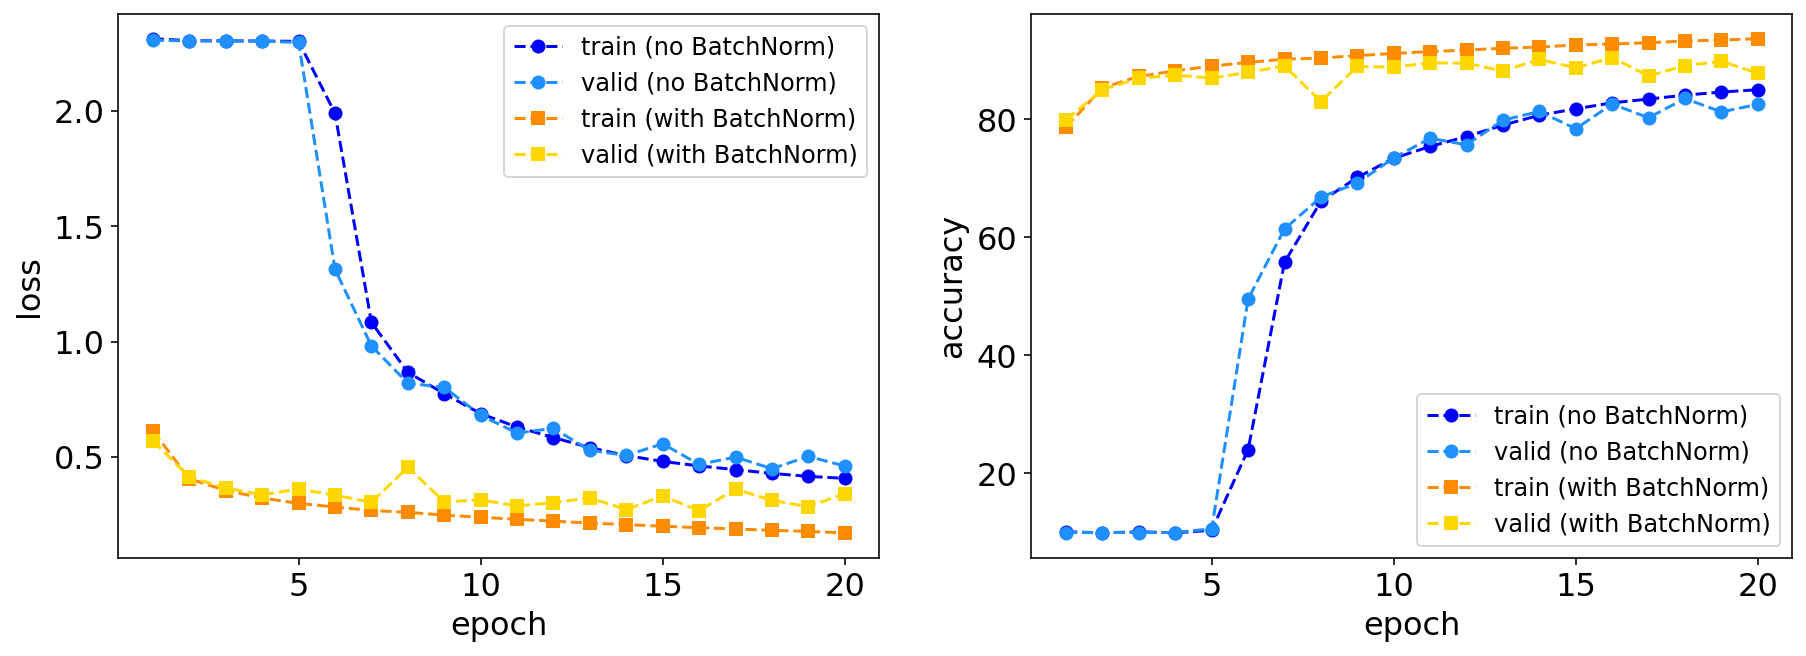

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1)[::], train_loss0[::], 'o--', label='train (no BatchNorm)', color='b')
ax[0].plot(range(1,num_epochs+1)[::], valid_loss0[::], 'o--', label='valid (no BatchNorm)', color='dodgerblue')
ax[1].plot(range(1,num_epochs+1)[::], train_acc0[::] , 'o--', label='train (no BatchNorm)', color='b')
ax[1].plot(range(1,num_epochs+1)[::], valid_acc0[::], 'o--', label='valid (no BatchNorm)', color='dodgerblue')

ax[0].plot(range(1,num_epochs+1)[::], train_lossB[::], 's--', label='train (with BatchNorm)', color='darkorange')
ax[0].plot(range(1,num_epochs+1)[::], valid_lossB[::], 's--', label='valid (with BatchNorm)', color='gold')
ax[1].plot(range(1,num_epochs+1)[::], train_accB[::] , 's--', label='train (with BatchNorm)', color='darkorange')
ax[1].plot(range(1,num_epochs+1)[::], valid_accB[::], 's--', label='valid (with BatchNorm)', color='gold')


ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

for i in range(2):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best', fontsize=12)